In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.metrics import roc_curve, confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import InputLayer, Conv2D, Flatten, Dense, Dropout, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [127]:
def plot_acc_loss(h):
    """
    Takes a history dictionary and plots accuracy and loss curves for
    train and validation datasets
    """
    
    acc, val_acc = h.history['accuracy'], h.history['val_accuracy']
    loss, val_loss = h.history['loss'], h.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [158]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [128]:
def print_cm(confmat):
    plt.figure(figsize=(7,7))
    sns.heatmap(confmat, annot=True, cmap='Blues', 
                square=True, fmt="d",
               xticklabels=test_generator.class_indices,
               yticklabels=test_generator.class_indices)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Prediction');

#print_cm(confmat)

In [129]:
def create_model_cnn(learning_rate = 0.001, activation = 'relu'):

    opt = Adam(learning_rate = learning_rate)

    model = Sequential()
    model.add(Conv2D(32, kernel_size = 3, input_shape = (224, 224, 3), activation = 'relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
    model.add(MaxPool2D())
    # Flatten the previous layer output
    model.add(Flatten())

    # Add as many outputs as classes with softmax activation
    model.add(Dense(2, activation = 'softmax'))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [159]:
train_dir = '/Users/jmichit/Documents/Metis/projects/eye_disease/other/data/train'
test_dir = '/Users/jmichit/Documents/Metis/projects/eye_disease/other/data/test'
val_dir = '/Users/jmichit/Documents/Metis/projects/eye_disease/other/data/validation'


train_datagen = ImageDataGenerator(rescale = 1. /255)

train_datagen_aug = ImageDataGenerator(rescale = 1. /255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True
                                  )

test_datagen = ImageDataGenerator(rescale = 1. /255)

size = (224, 224)
batch_size = 16

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical',
                    shuffle=True)

train_generator_aug = train_datagen_aug.flow_from_directory(
                    train_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical',
                    shuffle=False)

val_generator = ImageDataGenerator(rescale = 1. /255).flow_from_directory(
                    test_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical',
                    shuffle=False)

Found 1223 images belonging to 2 classes.
Found 1223 images belonging to 2 classes.
Found 1220 images belonging to 2 classes.
Found 1220 images belonging to 2 classes.


In [131]:
modelcheck = ModelCheckpoint("basic_cnn:{epoch:02d}-{val_loss:.2f}.h5",
                             monitor='val_loss',
                            save_best_only = True)

estop = EarlyStopping(monitor="val_loss",
                      patience = 4)

STEP_SIZE_TRAIN = train_generator_aug.n // train_generator_aug.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [132]:
model = create_model_cnn()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 373250    
Total params: 392,642
Trainable params: 392,642
Non-trainable params: 0
_______________________________________________

In [133]:
history = model.fit(
        train_generator_aug,
        steps_per_epoch = STEP_SIZE_TRAIN,
        epochs = 10,
        validation_data = test_generator,
        validation_steps = STEP_SIZE_TEST,
        callbacks=[estop, modelcheck])

Epoch 1/10
76/76 [==============================] - 33s 423ms/step - loss: 0.6555 - accuracy: 0.7768 - val_loss: 0.2345 - val_accuracy: 0.9260
Epoch 2/10
76/76 [==============================] - 32s 418ms/step - loss: 0.1938 - accuracy: 0.9401 - val_loss: 0.2648 - val_accuracy: 0.9301
Epoch 3/10
76/76 [==============================] - 32s 415ms/step - loss: 0.2345 - accuracy: 0.9322 - val_loss: 0.2705 - val_accuracy: 0.9252
Epoch 4/10
76/76 [==============================] - 32s 416ms/step - loss: 0.1845 - accuracy: 0.9407 - val_loss: 0.2338 - val_accuracy: 0.9137
Epoch 5/10
76/76 [==============================] - 32s 417ms/step - loss: 0.1628 - accuracy: 0.9432 - val_loss: 0.2109 - val_accuracy: 0.9268
Epoch 6/10
76/76 [==============================] - 31s 408ms/step - loss: 0.1587 - accuracy: 0.9534 - val_loss: 0.2038 - val_accuracy: 0.9276
Epoch 7/10
76/76 [==============================] - 33s 431ms/step - loss: 0.1454 - accuracy: 0.9537 - val_loss: 0.2388 - val_accuracy: 0.9202

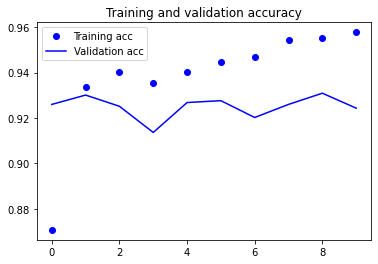

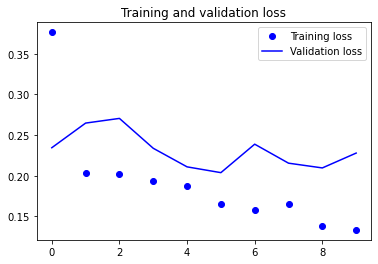

In [134]:
plot_acc_loss(history)

In [160]:
num_of_test_samples = test_generator.n


Y_pred = model.predict(x=val_generator, steps=len(val_generator) )
y_pred = np.argmax(Y_pred, axis=1)

In [161]:
y_pred

array([0, 0, 0, ..., 1, 0, 1])

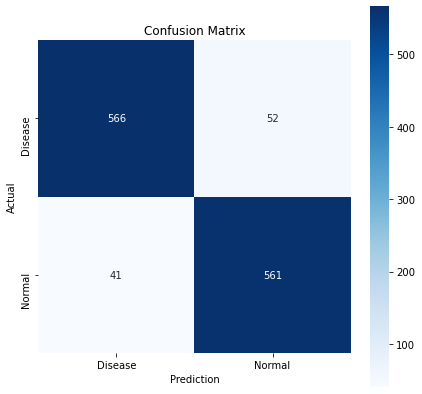

In [165]:
confmat = confusion_matrix(val_generator.classes, y_pred)

print_cm(confmat)

In [164]:
from sklearn.metrics import accuracy_score
accuracy_score(val_generator.classes, y_pred)

0.9237704918032786

In [154]:
imgs, labels = next(train_generator)

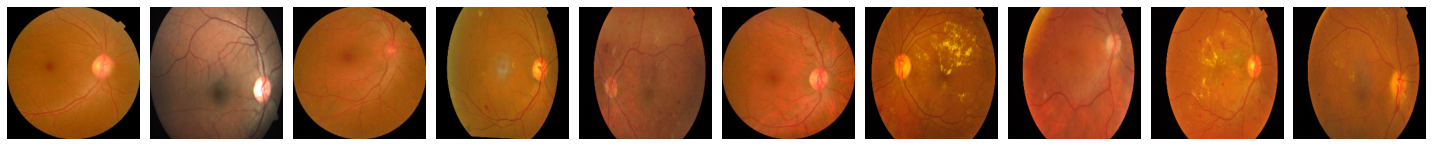

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [156]:
plotImages(imgs)
print(labels)

{'Disease': 0, 'Normal': 1}